Описание проекта: Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

Цель проекта: разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Ход исследования включает следующие этапы:

* Подготовка данных: Загрузка и изучение общей информации из предоставленных датасетов.
* Предобработка данных: Поиск и обработка пропущенных значений, удаление дубликатов, приведение названий столбцов к нижнему регистру, идентификация аномальных значений.
* Исследовательский анализ данных: Анализ распределений количественных и категориальных признаков в датасетах.
* Обучение моделей машинного обучения: Тестирование различных моделей для выбора наилучшей по метрике ROC_AUC.
* Оценка важности признаков: Оценка значимости входных признаков для модели.
* Анализ сегментов покупателей: Исследование различных сегментов покупателей и разработка рекомендаций для увеличения их покупательской активности.
* Общий вывод: Предложение наиболее эффективной модели машинного обучения для прогнозирования покупательской способности и разработка рекомендаций для повышения покупательской активности выбранного сегмента покупателей.

In [10]:
!pip install shap -q
!pip -q install phik
!pip install scikit-learn==1.1.3 -q

In [11]:
import shap
import phik
import pandas as pd
import numpy as np 
from scipy import stats as st 
from matplotlib import pyplot as plt
import seaborn as sns 
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_auc_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка данных

### Загрузите данные в датафреймы pandas.

In [16]:
try:
    data_file= pd.read_csv(r'C:\Users\dinos\Downloads\market_file.csv', sep=',')
    data_money= pd.read_csv(r'C:\Users\dinos\Downloads\market_money.csv', sep=',')
    data_time= pd.read_csv(r'C:\Users\dinos\Downloads\market_time.csv', sep=',')
    money= pd.read_csv(r'C:\Users\dinos\Downloads\money.csv', sep=';', decimal = ',')
    
except:
    data_file= pd.read_csv('/datasets/market_file.csv', sep=',')
    data_money= pd.read_csv('/datasets/market_money.csv', sep=',')
    data_time= pd.read_csv('/datasets/market_time.csv', sep=',')
    money= pd.read_csv('/datasets/money.csv', sep=';', decimal = ',')

pd.set_option('display.max_columns', None)

In [17]:
data = [data_file, data_money, data_time, money]

In [18]:
for i in data:
    df = i.head()
    df2 = i.info()
    display(df)
    display(df2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


None

Датасет имеет следующие особенности:

* Столбцы в основном соответствуют описанию, но некоторые имеют пробелы в названиях, что нужно исправить.
* Нет явных пропусков, количество значений в столбцах соответствует количеству строк.
* Рекомендуется привести названия столбцов к нижнему регистру и возможно сократить их, сохраняя смысл.
* Необходимо проверить данные на наличие явных и неявных дубликатов.

## Предобработка данных

Поиск и исправление ошибок в категориальных столбцах, а так же просмотр на неявные дубликаты

In [19]:
columns = ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']

for column in columns:
    print(data_file[column].value_counts())
    print('\n')

Прежний уровень    802
Снизилась          498
Name: Покупательская активность, dtype: int64


стандарт     914
премиум      376
стандартт     10
Name: Тип сервиса, dtype: int64


да     962
нет    338
Name: Разрешить сообщать, dtype: int64


Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64




In [8]:
data_file = data_file.replace('стандартт', 'стандарт')
data_file['Тип сервиса'].value_counts()

стандарт    924
премиум     376
Name: Тип сервиса, dtype: int64

In [22]:
data_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [23]:
data_money['Период'].value_counts()

препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: Период, dtype: int64

In [24]:
data_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [25]:
data_time = data_time.replace('предыдцщий_месяц', 'предыдущий_месяц')
data_time['Период'].value_counts()

текущий_месяц       1300
предыдущий_месяц    1300
Name: Период, dtype: int64

In [14]:
data_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Изменение название столбцов и приведение их к нижнему регистру

In [15]:
data_file.columns = data_file.columns.str.lower()
data_money.columns = data_money.columns.str.lower()
data_time.columns = data_time.columns.str.lower()
money.columns = money.columns.str.lower()

In [16]:
data_file = data_file.rename(columns={
    'покупательская активность':'активность',
    'тип сервиса':'сервис',
    'разрешить сообщать':'разрешить_сообщать',
    })

In [17]:
data_file.head()

,id,активность,сервис,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Поиск пропущенных значений

In [18]:
def pass_value_barh(dfg):
    try:
        ax = (
            (dfg.isna().mean()*100)
            .to_frame()
            .rename(columns={0:'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=(10,4), legend=False, fontsize=16, grid=True)
        )
        ax.set_title('Пропущенные значения, %' + "\n", fontsize=22, color='SteelBlue')
        ax.set_xlabel('Процент пропусков', fontsize=22)
        ax.set_ylabel('Столбцы с пропусками')
        plt.show()
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

пропусков не осталось :) или произошла ошибка в первой части функции 
пропусков не осталось :) или произошла ошибка в первой части функции 
пропусков не осталось :) или произошла ошибка в первой части функции 
пропусков не осталось :) или произошла ошибка в первой части функции 


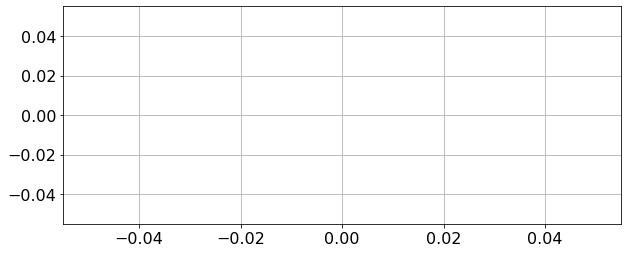

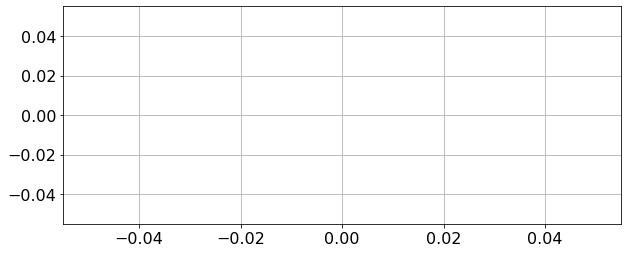

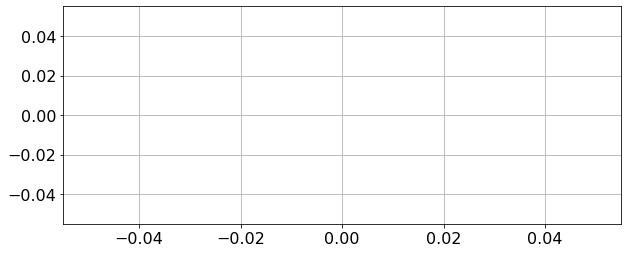

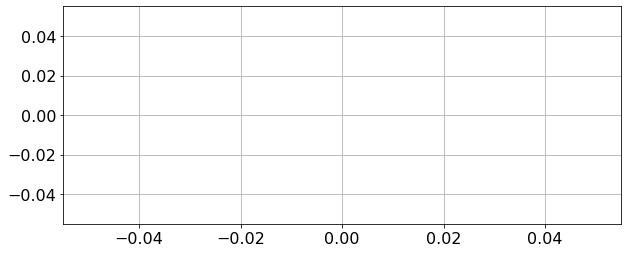

In [19]:
pass_value_barh(data_file)
pass_value_barh(data_money)
pass_value_barh(data_time)
pass_value_barh(money)

Поиск дубликатов

In [20]:
def duplicates(data):
    return data.duplicated().sum()
print(duplicates(data_file))
print(duplicates(data_money))
print(duplicates(data_time))
duplicates(money)

0
0
0


0

На данном этапе исследования были выполнены следующие шаги:

* Переименовывание колонок: В данном проекте разрешено использовать кириллические названия колонок, поэтому была произведена только замена пробелов на нижние подчеркивания.
* Обработка дублей: Дублей данных не обнаружено.
* Обработка пропусков: Были исследованы только категориальные признаки. Как оказалось, в таких колонках нет явных и неявных пропусков. Количественные признаки будут исследованы на следующем этапе исследования.

## Исследовательский анализ данных

In [21]:
for i in data:
    df = i.describe()
    display(df)

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


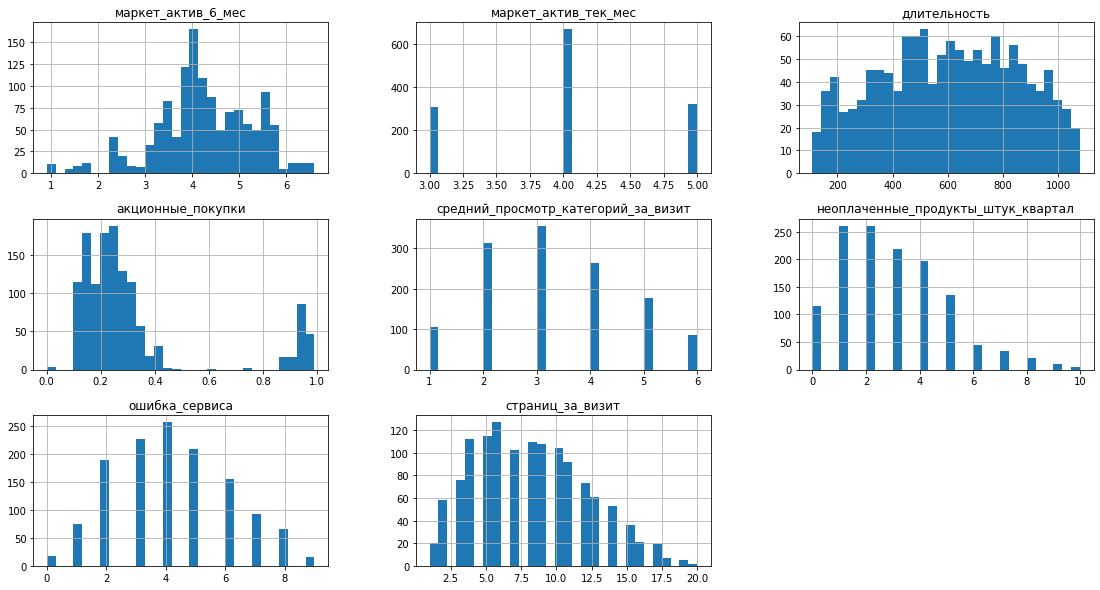

In [22]:
df_without_id = data_file.drop('id', axis=1)

# Plot histograms
df_without_id.hist(grid=True, figsize=(19, 10), bins=30);

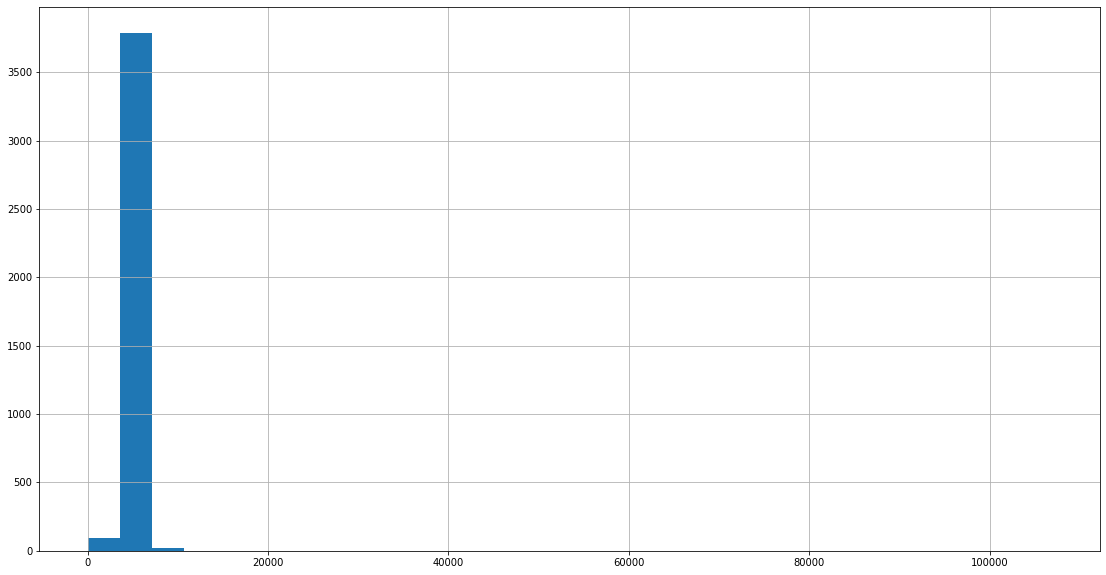

In [23]:
data_money['выручка'].hist(grid=True, figsize=(19, 10), bins=30);

In [24]:
data_money[data_money['выручка'] > 20000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


Выброс, от которого стоит избавиться.

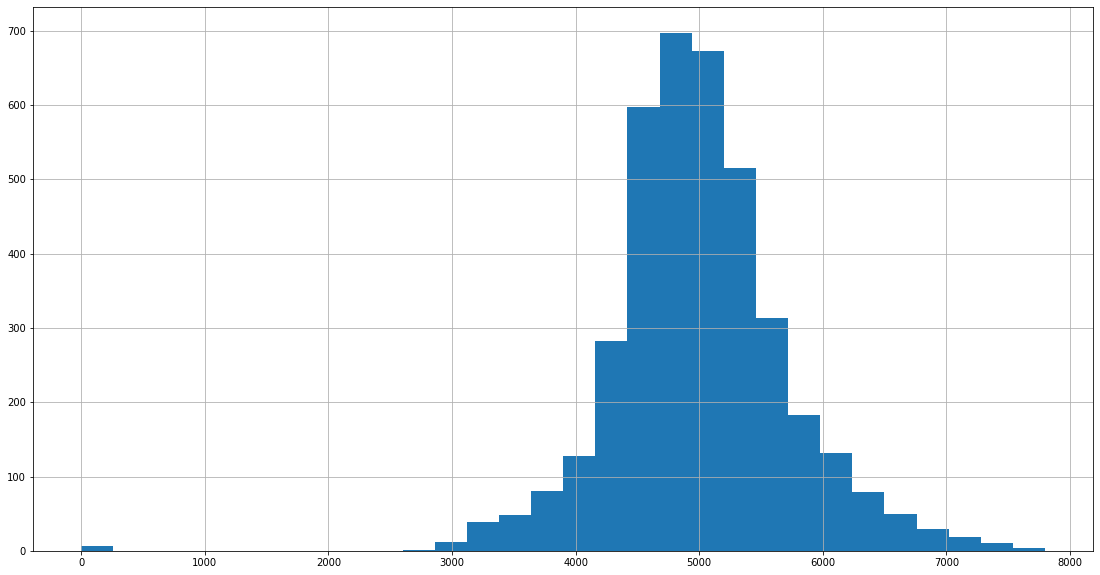

In [25]:
data_money = data_money.drop(index= 98)
data_money['выручка'].hist(grid=True, figsize=(19, 10), bins=30);

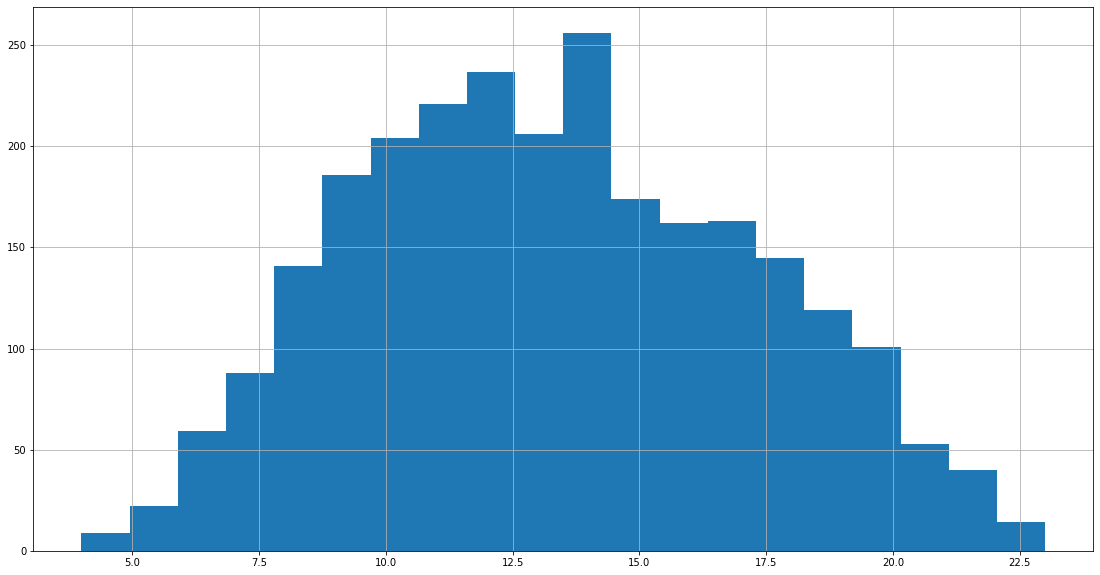

In [26]:
data_time['минут'].hist(grid=True, figsize=(19, 10), bins=20);

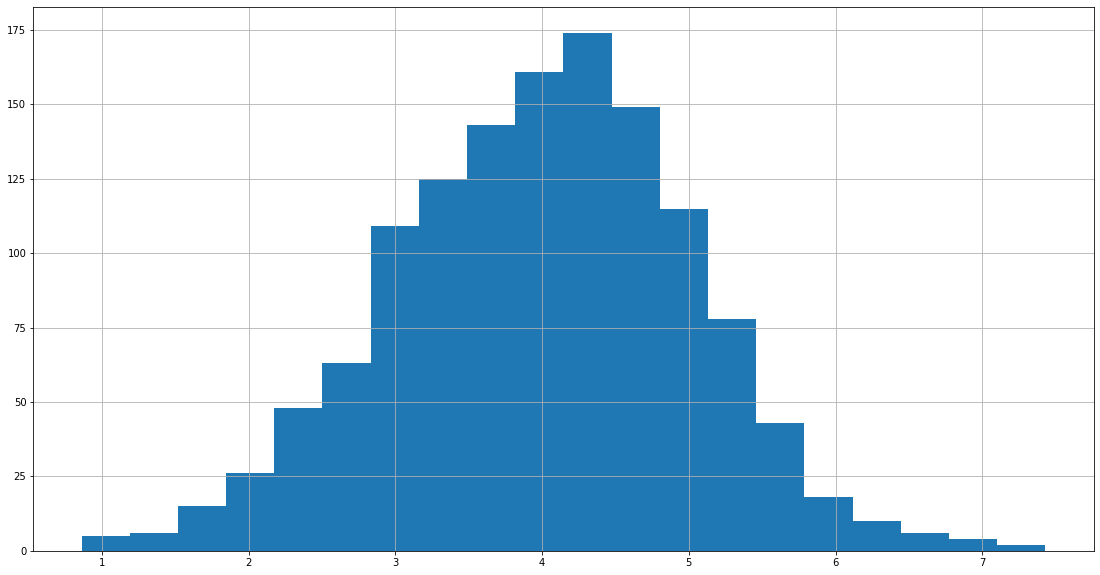

In [27]:
money['прибыль'].hist(grid=True, figsize=(19, 10), bins=20);

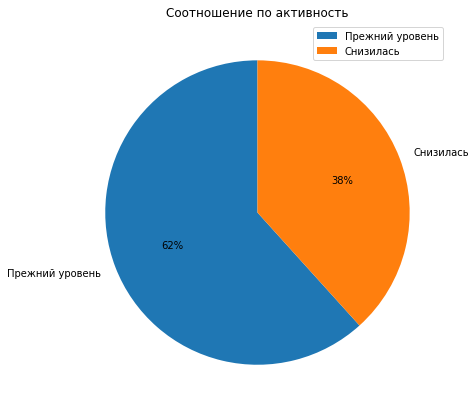

активность
Прежний уровень    61.69
Снизилась          38.31


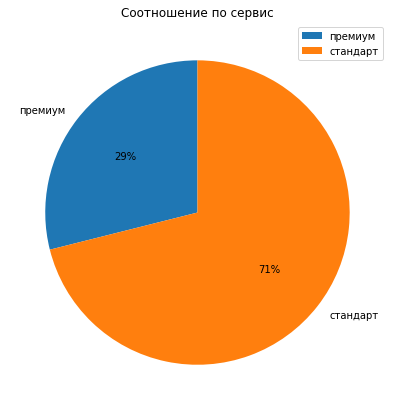

сервис
стандарт    71.08
премиум     28.92


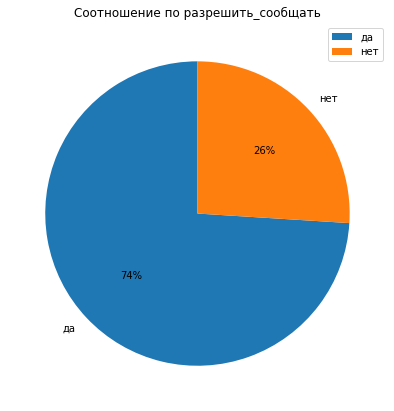

разрешить_сообщать
да     74.0
нет    26.0


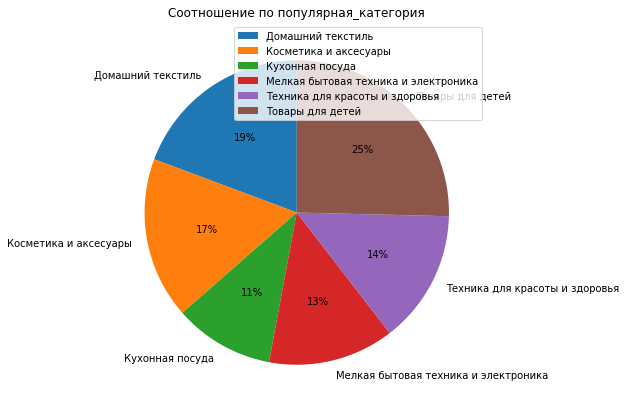

популярная_категория
Товары для детей                        25.38
Домашний текстиль                       19.31
Косметика и аксесуары                   17.15
Техника для красоты и здоровья          14.15
Мелкая бытовая техника и электроника    13.38
Кухонная посуда                         10.62


In [28]:
def plot_and_print_distribution(data, columns):
    for column in columns:
        data.pivot_table(index=column, values='id', aggfunc='count') \
            .plot.pie(y='id', figsize=(10,7), label='', title=f'Соотношение по {column}', autopct = "%.0f%%", startangle=90)
        plt.show()

        distribution = (data.groupby(column).size() / len(data) * 100).sort_values(ascending=False).round(2)
        print(distribution.to_string(index=True))

columns = ['активность', 'сервис', 'разрешить_сообщать', 'популярная_категория']

plot_and_print_distribution(data_file, columns)

In [29]:
data_money.query('выручка == 0')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [30]:
ids_to_remove = [215348, 215357, 215359]
dataframes = {'data_money': data_money, 'data_file': data_file, 'data_time': data_time, 'money': money}

for name, df in dataframes.items():
    df = df[~df['id'].isin(ids_to_remove)]
    print(f'{name}: {df.shape[0]}')


data_money: 3890
data_file: 1297
data_time: 2594
money: 1297


На данном этапе был проведен исследовательский анализ данных. В ходе работы было выявлено небольшое количество явно аномальных значений, которые были отброшены из рассмотрения. В целом данные выглядят хорошо. Так же оставили только пользователей, совершавших покупки в течении трех последних месяцев.

## Объединение таблиц

### Объедините таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании вам не понадобятся. 

In [31]:
market_money = data_money.pivot_table(index='id', columns='период', values='выручка').reset_index()
market_money.columns = ['id', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']

market_time = data_time.pivot_table(index='id', columns='период', values='минут').reset_index()
market_time.columns = ['id', 'минут_предыдущий_месяц', 'минут_текущий_месяц']

data_market = pd.merge(data_file, market_money, on='id', how='left')
data_market = pd.merge(data_market, market_time, on='id', how='left')
data_market

,id,активность,сервис,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


In [32]:
data_market.isna().sum()

id                                     0
активность                             0
сервис                                 0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  1
минут_предыдущий_месяц                 0
минут_текущий_месяц                    0
dtype: int64

In [33]:
data_market[data_market['выручка_текущий_месяц'].isnull() == True]

,id,активность,сервис,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7,6077.0,5051.0,NaN,12,14


In [34]:
data_market= data_market.dropna()
data_market.isna().sum()

id                                     0
активность                             0
сервис                                 0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  0
минут_предыдущий_месяц                 0
минут_текущий_месяц                    0
dtype: int64

In [35]:
data_market.query('выручка_препредыдущий_месяц == 0')

,id,активность,сервис,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
9,215357,Снизилась,стандарт,да,3.9,5,154,0.0,Техника для красоты и здоровья,3,3,9,5,0.0,0.0,5986.3,12,6
11,215359,Снизилась,стандарт,да,4.6,5,110,0.0,Домашний текстиль,4,2,4,2,0.0,0.0,4735.0,13,11


In [36]:
data_market = data_market.loc[data_market['выручка_предыдущий_месяц'] != 0]
data_market.query('выручка_препредыдущий_месяц == 0')

,id,активность,сервис,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц


В ходе соединения таблиц был выявлен строка с пропущенным значением и 0 в выручке.

## Корреляционный анализ

In [37]:
data_market.corr(method='spearman')

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,1.000000,0.339623,-0.006304,-0.061854,-0.378705,0.280727,-0.257957,0.099048,0.527855,-0.077211,0.342599,-0.095387,0.486838,0.434028
маркет_актив_6_мес,0.339623,1.000000,0.061741,-0.044445,-0.276590,0.185013,-0.135045,0.038643,0.319872,-0.003642,0.234728,0.002093,0.273727,0.226968
маркет_актив_тек_мес,-0.006304,0.061741,1.000000,-0.131967,0.033099,-0.025167,0.061747,0.087343,0.003143,-0.027088,-0.039437,-0.011782,0.013535,-0.063051
длительность,-0.061854,-0.044445,-0.131967,1.000000,0.029045,-0.043154,-0.108787,0.103562,-0.034495,0.013537,-0.039301,0.015002,-0.123940,0.083048
акционные_покупки,-0.378705,-0.276590,0.033099,0.029045,1.000000,-0.203401,0.198307,-0.051593,-0.370860,0.005184,-0.269087,0.022255,-0.332548,-0.275313
средний_просмотр_категорий_за_визит,0.280727,0.185013,-0.025167,-0.043154,-0.203401,1.000000,-0.251559,0.010034,0.267479,-0.049460,0.149742,-0.070716,0.148279,0.233369
неоплаченные_продукты_штук_квартал,-0.257957,-0.135045,0.061747,-0.108787,0.198307,-0.251559,1.000000,-0.098582,-0.165412,0.033434,-0.249293,0.061178,-0.183575,-0.214699
ошибка_сервиса,0.099048,0.038643,0.087343,0.103562,-0.051593,0.010034,-0.098582,1.000000,0.104482,0.035476,0.090152,0.040477,0.196009,0.078074
страниц_за_визит,0.527855,0.319872,0.003143,-0.034495,-0.370860,0.267479,-0.165412,0.104482,1.000000,-0.067610,0.311675,-0.049964,0.450760,0.298120
выручка_предыдущий_месяц,-0.077211,-0.003642,-0.027088,0.013537,0.005184,-0.049460,0.033434,0.035476,-0.067610,1.000000,0.308041,0.879097,-0.084215,-0.083214


interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


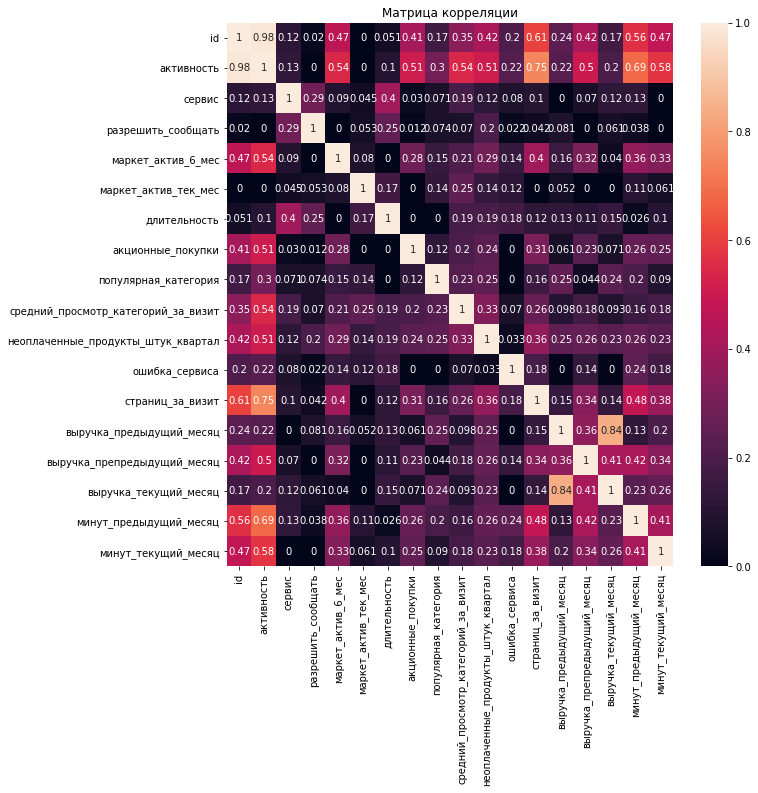

In [38]:
corr_matrix = data_market.phik_matrix()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='rocket')
plt.title('Матрица корреляции')
plt.show()

Целевым признаком является активность, и вот список полей, которые имеют хоть какую-то корреляцию с ним: 
* Маркет_актив_6_мес, 
* Акционные_покупки, 
* Средний_просмотр_категорий_за_визит, 
* Неоплаченные_продукты_штук_квартал, 
* Страниц_за_визит, 
* Выручка_предыдущий_месяц, 
* минут_предыдущий_месяц, 
* минут_текущий_месяц.

Наблюдается высокая корреляция между выручками за предыдущий и текущий месяцы. Возможно стоит объединить эти данные в один столбец. А также убрать столбец id


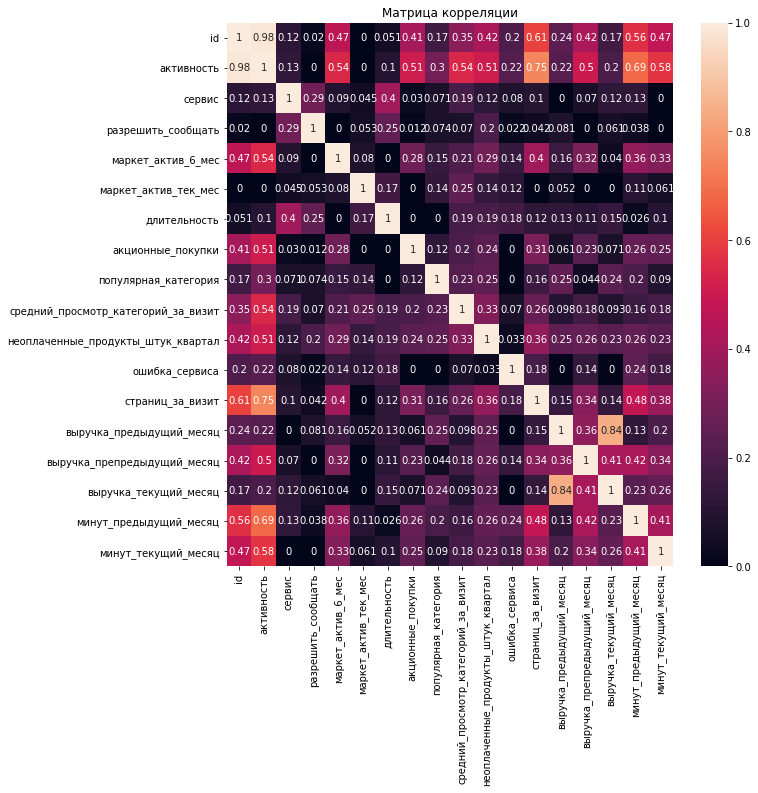

In [39]:
data_market = data_market.copy()
data_market['выручка_пред_тек'] = data_market['выручка_предыдущий_месяц'] + data_market['выручка_текущий_месяц']
data_market = data_market.set_index('id')

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='rocket')
plt.title('Матрица корреляции')
plt.show()

In [40]:
data_market.head()

,активность,сервис,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,выручка_пред_тек
id,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,10187.6
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,10515.9
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,12768.4
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,11680.0
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,10127.0


## Использование пайплайнов

### Во время подготовки данных используйте ColumnTransformer. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.

In [41]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [42]:
X = data_market.drop(['активность', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц'], axis=1)
y = data_market['активность']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

In [43]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [44]:
cat_col = ['разрешить_сообщать', 
           'популярная_категория']

ord_columns = ['сервис']

#количественные
num_col = ['маркет_актив_6_мес', 
           'длительность', 
           'акционные_покупки',
           'страниц_за_визит', 
           'выручка_препредыдущий_месяц', 
           'выручка_пред_тек', 
           'минут_текущий_месяц', 
           'минут_предыдущий_месяц', 
           'маркет_актив_тек_мес',
           'средний_просмотр_категорий_за_визит',
           'неоплаченные_продукты_штук_квартал', 
           'ошибка_сервиса'] 

In [45]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
])

In [46]:
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_ord_before',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[
                                      ['Редко покупает по акции','Часто покупает по акции']],
                          handle_unknown='use_encoded_value',
                          unknown_value=np.nan)
        ),
        (
            'simple_imputer_ord_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [47]:
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, cat_col),
    ('ord', ord_pipe, ord_columns),
    ('num', StandardScaler(), num_col)
], remainder='passthrough')

In [48]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

### Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.

In [49]:
param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    'models': [
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        KNeighborsClassifier(),
        SVC(random_state=RANDOM_STATE),
        LogisticRegression(random_state=RANDOM_STATE)
    ]
}

In [50]:
param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }
] 

Выбор оптимальной модели без перебора гиперпараметров

In [51]:
#поиск оптимальной модели без перебора гиперпараметров
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1
)

#обучение модели на тренировочной выборке
grid.fit(X_train, y_train)

#вывод лучшей модели
print('Лучшая модель и её параметры:\n\n', grid.best_params_)

Лучшая модель и её параметры:

 {'models': SVC(random_state=42), 'preprocessor__num': StandardScaler()}


 Метрика ROC AUC выбрана для GridSearchCV из-за её способности давать сбалансированную и обобщённую оценку качества модели независимо от порогов, устойчивости к несбалансированным данным, ясного понимания различения классов (значения от 0 до 1 показывают качество модели) и баланса между полнотой и точностью.

In [52]:
#вывод метрики лучшей модели
print('Метрика ROC-AUC для лучшей модели:\n', round(grid.best_score_, 4)) 

Метрика ROC-AUC для лучшей модели:
 0.9089


Выбор оптимальной модели с перебором гиперпараметров

In [53]:
grid_1 = GridSearchCV(
    pipe_final, 
    param_grid=param_distributions, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
)

#обучение модели на тренировочной выборке
grid_1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         ['разрешить_сообщать',
                                                                          'популярная_категория']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simple_imputer_ord_before'...
                                                'passthrough']},
                         {'models': [SVC(C=2, probability=True,
                                         random_state=42)],
                          'models__C': range(1, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': range(1, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [54]:
print('Метрика ROC-AUC для лучшей модели:\n', round(grid_1.best_score_, 4)) 
print('\nЛучшая модель и её параметры:\n\n', grid_1.best_params_) 

Метрика ROC-AUC для лучшей модели:
 0.9091

Лучшая модель и её параметры:

 {'models': SVC(C=2, probability=True, random_state=42), 'models__C': 2, 'preprocessor__num': StandardScaler()}


Лучшей моделью снова оказалась SVC с roc_auc = 0.9091

In [55]:
y_pred = grid_1.predict(X_test)
y_predict_proba = grid_1.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_predict_proba[:, 1]), 4)}')
print(f'Метрика F1-score на тестовой выборке: {round(f1_score(y_test, y_pred, average="binary"), 2)}')

Метрика ROC-AUC на тестовой выборке: 0.9125
Метрика F1-score на тестовой выборке: 0.86


На данном шаге исследования была найдена и обучена модель для определения снижения активности покупателей сервиса. Лучшие результаты показала модель SVC с параметрами probability=True и random_state=42. Метрика ROC AUC для тестовой выборки показала результат 0.912, а для тренировочной выборки 0.909. Эти показатели очень хорошие, что свидетельствует о том, что наша модель хорошо справляется с предсказанием. Однако, метрика F1 показала чуть хуже результат, равный 0.86.

## Анализ важности признаков

### Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 

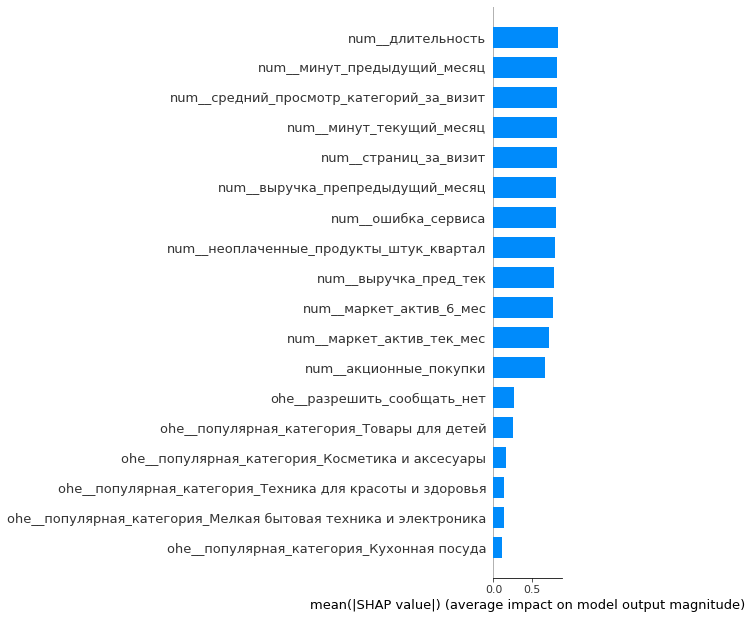

In [56]:
#поиск важных признаков
X_encoded_1 = grid_1.best_estimator_['preprocessor'].fit_transform(X_train)

model_1 = grid_1.best_estimator_['models'].fit(X_encoded_1, y_train)
explainer_1 = shap.PermutationExplainer(model_1, X_encoded_1)


labels_1 = grid_1.best_estimator_[:-1].get_feature_names_out()

shap.summary_plot(X_encoded_1, plot_type='bar', feature_names=labels_1) 

#### Выводы о значимости признаков:
Наиболее важными признаками являются длительность (с момента регистрации пользователя), минуты (время, проводимое на сайте), количество просмотренных страниц и количество категорий за визит. Существует множество признаков, которые почти одинаково важны, начиная от длительности до количества покупок по акциям. По всем этим признакам можно попробовать разбить покупателей на сегменты для более точного анализа и таргетирования.

Такое сегментирование позволит лучше понять поведение различных групп пользователей и разработать стратегии для увеличения их покупательской активности.

## Сегментация покупателей

### Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.

In [57]:
y_test_proba = grid_1.predict_proba(X_test)[:,1]
y_train_proba = grid_1.predict_proba(X_train)[:,1]
money = money.set_index('id')

In [58]:
X_test_full = X_test.copy()
X_train_full = X_train.copy()
X_test_full['вероятность_снижения'] = y_test_proba
X_train_full['вероятность_снижения'] = y_train_proba
df = pd.concat([X_train_full, X_test_full])
df = df.join(money)
df.head()

,сервис,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,выручка_пред_тек,вероятность_снижения,прибыль
id,,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,0.15,Мелкая бытовая техника и электроника,2,4,7,16,4347.0,20,6,11184.7,0.074125,4.37
215361,стандарт,да,5.1,4,199,0.23,Техника для красоты и здоровья,4,5,2,3,4597.0,11,13,10189.7,0.786334,4.03
215884,стандарт,да,4.3,5,997,0.17,Мелкая бытовая техника и электроника,5,1,3,11,4626.0,13,10,7911.4,0.093189,4.37
216564,стандарт,да,5.6,4,342,0.94,Кухонная посуда,2,7,5,8,5269.0,14,19,9696.2,0.172460,5.58
215715,премиум,да,3.6,5,873,0.39,Товары для детей,3,2,2,5,4691.0,10,10,8316.0,0.971451,4.87


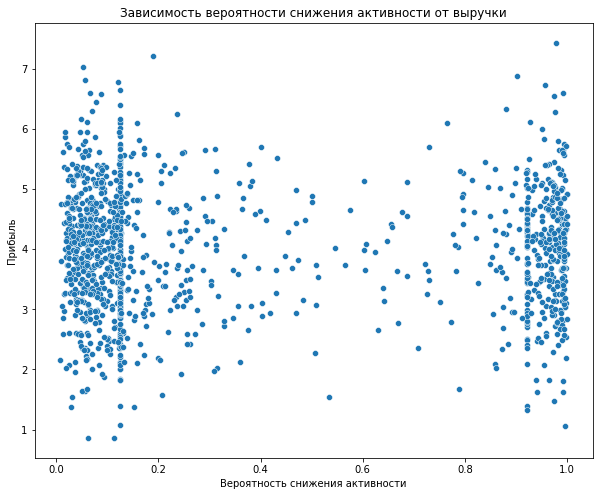

In [59]:
fig = plt.figure(figsize=(10,8))
sns.scatterplot(data=df, y='прибыль', x='вероятность_снижения')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')
plt.title('Зависимость вероятности снижения активности от выручки')
plt.show()

На диаграмме рассеяния не наблюдается явной зависимости между вероятностью снижения активности пользователя и прибылью.

In [60]:
def build_scatterplots(cat_columns):
    for cat_col in cat_columns:
        fig = plt.figure(figsize=(10,8))
        sns.scatterplot(data=df, y='прибыль', x='вероятность_снижения', hue=cat_col)
        plt.xlabel('Вероятность снижения активности')
        plt.ylabel('Прибыль')
        plt.title('Зависимость вероятности снижения активности от выручки')
        plt.show()

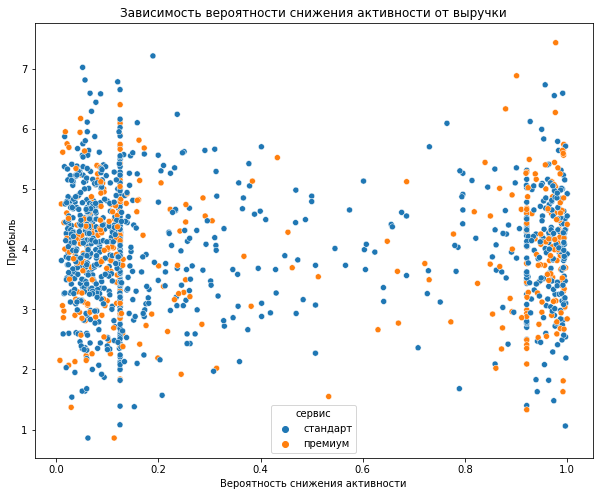

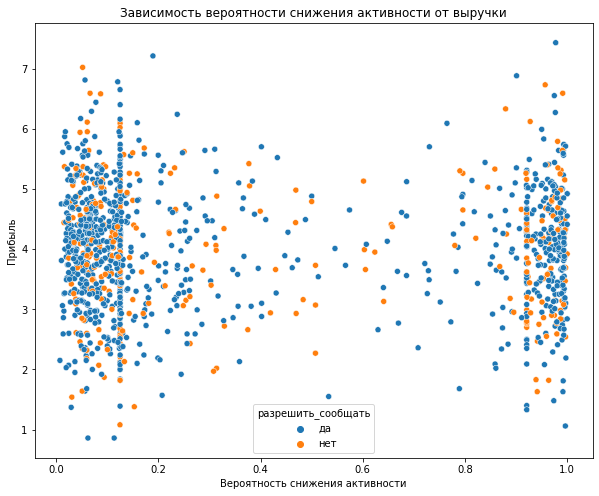

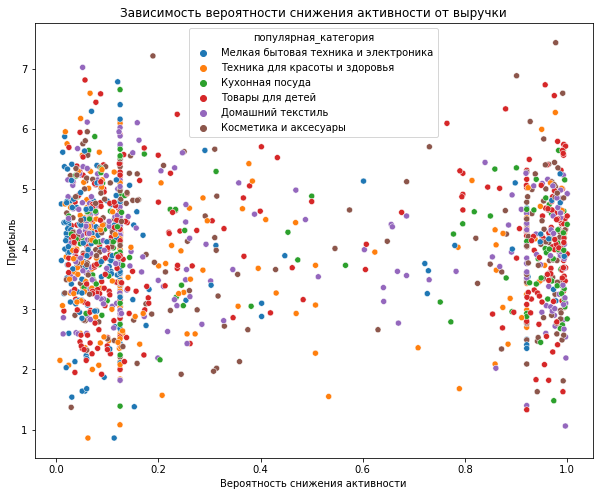

In [61]:
cat_columns = list(df.select_dtypes(include='object').columns)
build_scatterplots(cat_columns)

По категориальным признакам тоже ничего нету. Добавим новый бинарный признак по покупкам акций 

In [62]:
df['акционные_покупки_категория'] = df['акционные_покупки']\
.apply( lambda x: 'Часто покупает по акции' if x>= 0.5 else 'Редко покупает по акции' )
df = df.drop(['акционные_покупки'], axis=1)

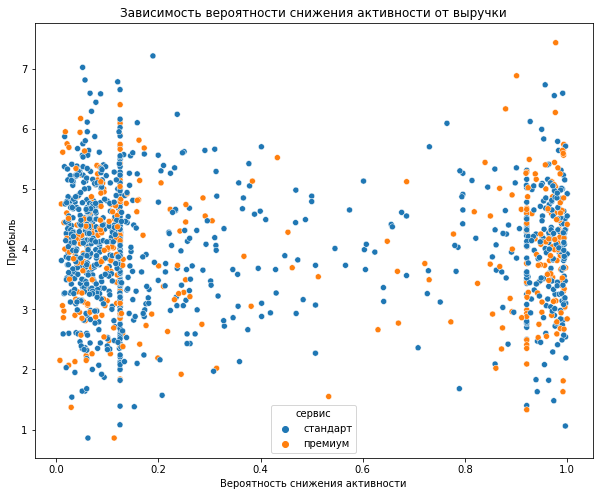

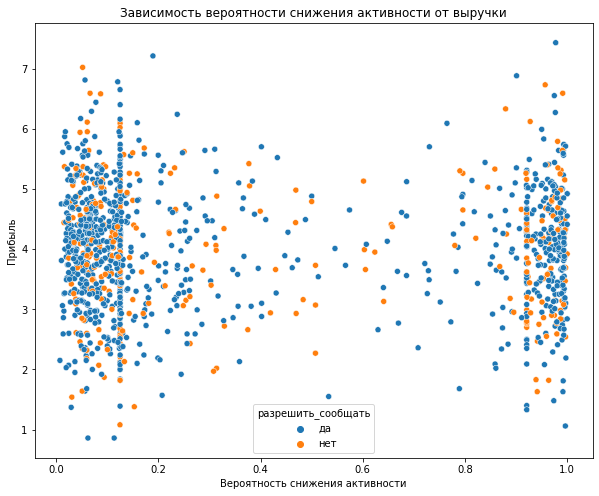

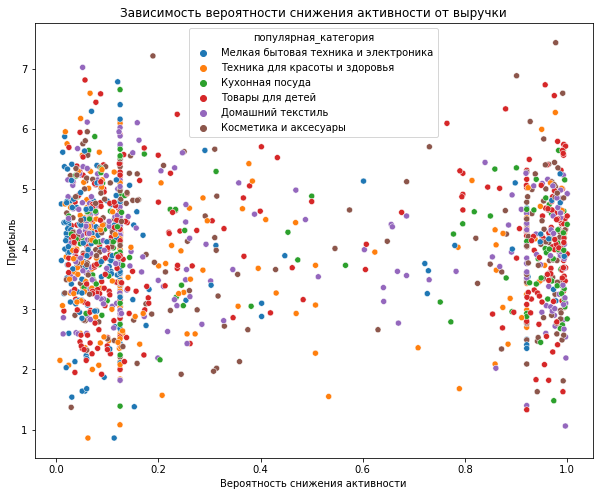

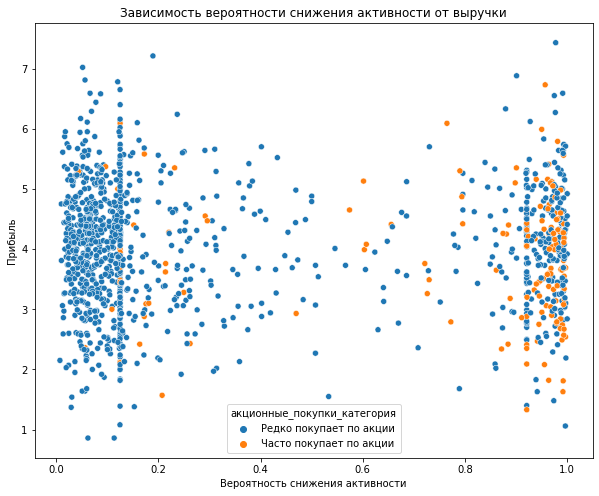

In [63]:
cat_columns = list(df.select_dtypes(include='object').columns)
build_scatterplots(cat_columns)

Пользователи, которые часто покупают по скидке, чаще всего имеют высокую вероятность снижения активности. Это объясняется тем, что скидки не бывают постоянными, поэтому покупки этот сегмент пользователей совершает сезонно. Более того, пользователи, покупающие в основном по скидке, представлены по всему распределению прибыли.

Попробуем проанализировать этот сегмент. Для этого добавим колонку и в ней промаркируем пользователей, которые часто покупают по акции и имеют вероятность снижения активности более 80%.

In [64]:
df['сегмент'] = df\
.apply( lambda row: 'Исследуемый сегмент' \
        if row['вероятность_снижения'] > 0.8 and row['акционные_покупки_категория']=='Часто покупает по акции' \
        else 'Остальные пользователи' \
      , axis=1)
df

,сервис,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,выручка_пред_тек,вероятность_снижения,прибыль,акционные_покупки_категория,сегмент
id,,,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,Мелкая бытовая техника и электроника,2,4,7,16,4347.0,20,6,11184.7,0.074125,4.37,Редко покупает по акции,Остальные пользователи
215361,стандарт,да,5.1,4,199,Техника для красоты и здоровья,4,5,2,3,4597.0,11,13,10189.7,0.786334,4.03,Редко покупает по акции,Остальные пользователи
215884,стандарт,да,4.3,5,997,Мелкая бытовая техника и электроника,5,1,3,11,4626.0,13,10,7911.4,0.093189,4.37,Редко покупает по акции,Остальные пользователи
216564,стандарт,да,5.6,4,342,Кухонная посуда,2,7,5,8,5269.0,14,19,9696.2,0.172460,5.58,Часто покупает по акции,Остальные пользователи
215715,премиум,да,3.6,5,873,Товары для детей,3,2,2,5,4691.0,10,10,8316.0,0.971451,4.87,Редко покупает по акции,Остальные пользователи
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215429,премиум,нет,0.9,4,690,Домашний текстиль,2,5,7,4,4488.0,11,10,7820.6,0.868047,3.71,Редко покупает по акции,Остальные пользователи
216233,премиум,да,3.9,4,1048,Техника для красоты и здоровья,3,0,6,14,4553.0,15,17,8582.4,0.110422,4.62,Редко покупает по акции,Остальные пользователи
215716,стандарт,да,2.4,4,952,Техника для красоты и здоровья,3,5,2,3,4165.0,13,14,6410.9,0.860802,4.07,Редко покупает по акции,Остальные пользователи


In [65]:
df['сегмент'].value_counts()

Остальные пользователи    1176
Исследуемый сегмент        120
Name: сегмент, dtype: int64

In [66]:
df_segment = df[df['сегмент'] == 'Исследуемый сегмент']
df_segment.head()

,сервис,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,выручка_пред_тек,вероятность_снижения,прибыль,акционные_покупки_категория,сегмент
id,,,,,,,,,,,,,,,,,,
215448,премиум,да,4.6,4,974,Домашний текстиль,4,3,3,7,4670.0,9,10,11480.7,0.950441,2.95,Часто покупает по акции,Исследуемый сегмент
215382,стандарт,да,4.6,4,330,Техника для красоты и здоровья,6,2,7,6,4824.0,15,8,11949.0,0.884222,2.42,Часто покупает по акции,Исследуемый сегмент
215732,стандарт,нет,3.5,4,663,Косметика и аксесуары,3,6,4,3,4955.0,16,11,11582.3,0.953762,3.51,Часто покупает по акции,Исследуемый сегмент
215537,премиум,да,3.9,4,705,Косметика и аксесуары,3,3,7,4,4974.0,7,9,12903.4,0.992099,1.81,Часто покупает по акции,Исследуемый сегмент
215741,стандарт,да,4.8,4,563,Товары для детей,1,5,7,4,4809.0,10,14,8554.4,0.920819,4.29,Часто покупает по акции,Исследуемый сегмент


array(['Домашний текстиль', 'Техника для красоты и здоровья',
       'Косметика и аксесуары', 'Товары для детей', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

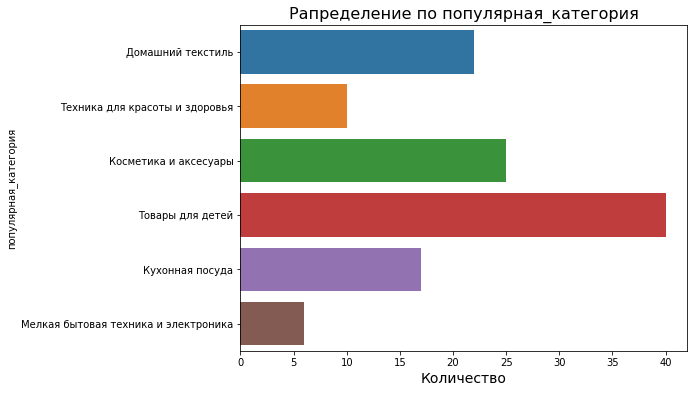

In [67]:
def categoral_unique(df, col):
    display(df[col].unique())
    
    plt.figure(figsize=(8,6))
    plot = sns.countplot(y=col, data=df)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_xlabel('Количество', fontsize=14)
categoral_unique(df_segment, 'популярная_категория')

array(['премиум', 'стандарт'], dtype=object)

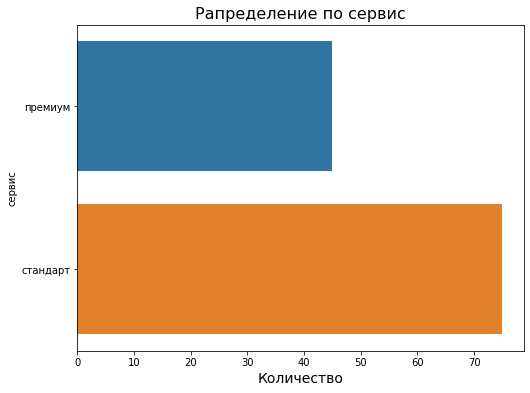

In [68]:
categoral_unique(df_segment, 'сервис')

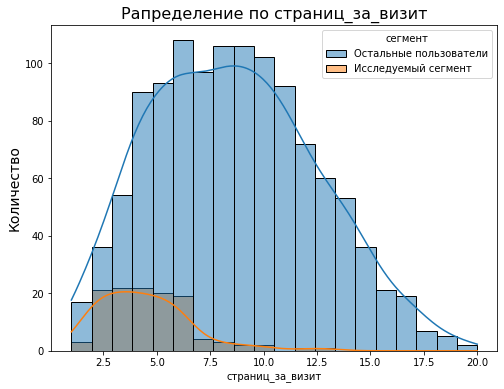

In [69]:
def histogram(df, col, target):
    plt.figure(figsize=(8,6))
    plot = sns.histplot(df, bins=20, kde=True, hue=target, x=col)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_ylabel('Количество', fontsize=14)
histogram(df, 'страниц_за_визит', 'сегмент')

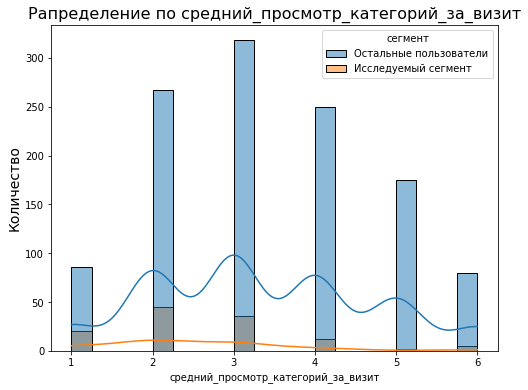

In [70]:
histogram(df, 'средний_просмотр_категорий_за_визит', 'сегмент')

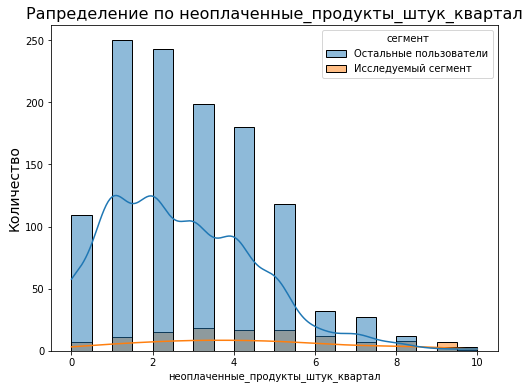

In [71]:
histogram(df, 'неоплаченные_продукты_штук_квартал', 'сегмент')

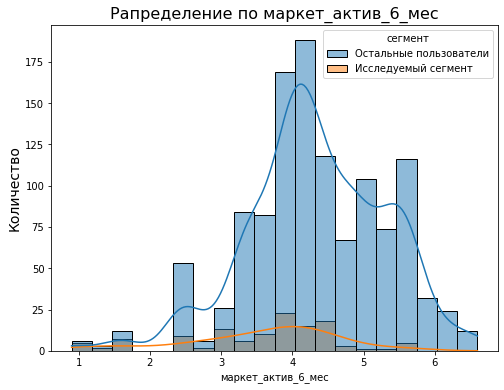

In [72]:
histogram(df, 'маркет_актив_6_мес', 'сегмент')

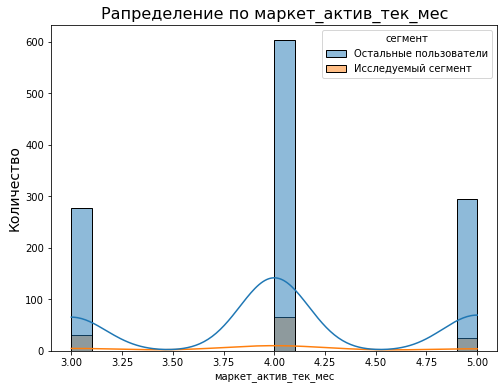

In [73]:
histogram(df, 'маркет_актив_тек_мес', 'сегмент')

Покупатели, совершающие покупки по акциям, получают такое же количество внимания от маркетплейса, как и все остальные пользователи. Это означает, что магазин не предоставляет им дополнительных источников информации о скидках. Вся информация либо содержится в письмах, которые получают все пользователи, либо размещена на главной странице сайта.

Мы рассмотрели некоторые признаки сегмента пользователей, которые покупают по скидке и имеют высокую вероятность снижения покупательской активности. Попробуем их описать: это пользователи, которые проводят не так много времени на сайте. Они не сравнивают товары, не выбирают лучший; они просматривают один-два товара и совершают покупку.

Что можно предпринять, чтобы этот сегмент покупателей приносил больше прибыли? Вот мои предложения:

* Не тратить средства на рассылки. Я не думаю, что человек, который не хочет просматривать страницы с товарами, будет читать рекламные материалы.

* Сосредоточиться на главной странице сайта и таргетировать её под конкретного покупателя. Скидки должны как можно чаще обновляться на главной странице, чтобы у покупателя была одна страница, которую он может быстро пролистать, не переходя по другим страницам.

## Общий вывод

Исследование было направлено на создание модели для прогнозирования снижения покупательской активности в интернет-магазине "В один клик" и анализ выбранного сегмента пользователей.

Этапы исследования:

1. Загрузка данных:
В исследовании использовались четыре csv файла:

* данные о поведении покупателей на сайте и их взаимодействии с магазином,
* информация о выручке от каждого покупателя,
* время, проведённое покупателями на сайте,
* средняя месячная прибыль за последние три месяца. Данные были загружены в датафреймы с помощью библиотеки pandas.

2. Предобработка данных:
Данные были хорошего качества, но потребовали некоторых подготовительных работ:

* стандартизация имён признаков: пробелы заменены на подчеркивания.
* обработка ошибок в данных
* обработка пропусков: пропусков не было.

3. исследовательский анализ данных:

Были выявлены небольшое количество явно аномальных значений, которые были отброшены из рассмотрения. Так же оставили только пользователей, совершавших покупки в течении трех последних месяцев.

4. Объединение таблиц:

Датасеты были объединены в один датафрейм.

5. Корреляционный анализ:

Целевой признак - Покупательская активность. Были выявлены корреляции с признаками: Маркет_актив_6_мес, Акционные_покупки и другие.

6. Обучение модели:

Были обучены модели KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression и SVC с использованием пайплайнов sklearn. Лучшая модель - SVC с параметрами probability=True и random_state=42 с метрикой roc_auc 0.90 для обучающей выборки и 0.91 для тестовой. Метрика f1 = 0.90.

7. Анализ важности признаков:

Самыми важными оказались признаки, связанные с количеством времени, проведённым на сайте. Менее важны - категории товаров и коммуникации с пользователем.

8. Сегментация пользователей:

Для анализа был выбран сегмент пользователей, часто покупающих по скидке и имеющих высокую вероятность снижения покупательской активности. Моё предложение по увеличению активности этого сегмента – таргетированная настройка главной страницы маркетплейса и более частое обновление скидок на главной странице. Пользователь не хочет переходить по страницам, он хочет видеть все предложения в одном месте.